# Relationship Analysis

### General pre-work

In [112]:
# Import necessary libraries
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import os

In [113]:
output_folder = 'data/analysis' # refer to a new folder to store only sentiment result files

# check if folder can be found, else create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Add the normal distribution stock values to the combined sentiment table
csv_file_path_normal_3 = 'data/transfer/cleaned_articles_normalverteilt_3.csv'
csv_file_path_combined_sentiments = 'data/sentiment_results/sentiment_results_combined.csv'
csv_file_path_topics = 'data/transfer/topic_modeling.csv'

# Load the data set
df_3categories_normal = pd.read_csv(csv_file_path_normal_3, encoding='utf-8', quoting=csv.QUOTE_ALL)
df_topics = pd.read_csv(csv_file_path_topics, encoding='utf-8', quoting=csv.QUOTE_ALL)
df_combined_sentiments = pd.read_csv(csv_file_path_combined_sentiments, encoding='utf-8', quoting=csv.QUOTE_ALL) # ensuring the right encoding as in the csv file we still encounter incorrectly encoded special characters

## Pre-Processing

In [114]:
# Merge the two data frames based on a common column, such as an index or a specific column name
df_merged_3_categories = df_combined_sentiments.merge(df_3categories_normal[['Stock_ValueStd']], left_index=True, right_index=True)
print(df_merged_3_categories.head(3))

   Row_Number                   Unternehmen Newstyp   Quelle Nearest_Date   
0           1  Porsche Automobil Holding SE    News  onvista   2021-06-01  \
1           2                    Beiersdorf    News  onvista   2021-06-02   
2           3          Heidelberg Materials    News  onvista   2021-06-02   

                                        Cleaned_Text Stock_Value   
0  neu Rumor Porschebörsengang Sixt Berenberg stu...     neutral  \
1  Beiersdorf Aktie Kaufempfehlung beflügeln Bere...    positive   
2  Heidelbergcement klimaneutral Zementwerk Weg B...    positive   

   TextBlob_Sentiment_Score TextBlob_Evenly_Separated_Label   
0                   -0.0500                        Negative  \
1                    0.2000                        Positive   
2                   -0.0875                        Negative   

  TextBlob_Normal_Distribution_Label  NLTK_Sentiment   
0                            Neutral         -0.3612  \
1                           Positive          0.0000 

In [115]:
#Rename and reposition columns

# Rename column "Stock_Value" to "Stock_Value_evenly_separated"
df_merged_3_categories.rename(columns={'Stock_Value': 'Stock_Value_Evenly_Separated'}, inplace=True)

# Rename column "Stock_ValueStd" to "Stock_Value_normal_distribution"
df_merged_3_categories.rename(columns={'Stock_ValueStd': 'Stock_Value_Normal_Distribution'}, inplace=True)

# Reorder columns to move "Stock_Value_normal_distribution" to the 8th column
cols = df_merged_3_categories.columns.tolist()
cols.insert(7, cols.pop(cols.index('Stock_Value_Normal_Distribution')))
df_merged_3_categories = df_merged_3_categories[cols]

# Capitalize the stock value
df_merged_3_categories['Stock_Value_Evenly_Separated'] = df_merged_3_categories['Stock_Value_Evenly_Separated'].str.capitalize()
df_merged_3_categories['Stock_Value_Normal_Distribution'] = df_merged_3_categories['Stock_Value_Normal_Distribution'].str.capitalize()
df_merged_3_categories_topics = df_merged_3_categories.merge(df_topics[['cluster_words']], left_index=True, right_index=True)

In [116]:
# Save the merged file in the correct repository folder

# Save to an Excel file
excel_output_file_analysis_3 = os.path.join(output_folder, 'analysis_3_categories.xlsx')
df_merged_3_categories.to_excel(excel_output_file_analysis_3, index=False)
excel_output_file_analysis_3_topics = os.path.join(output_folder, 'analysis_3_categories_topics.xlsx')
df_merged_3_categories_topics.to_excel(excel_output_file_analysis_3_topics, index=False)

# Save the results to a csv file with the same name
csv_output_file_analysis_3 = os.path.join(output_folder, 'analysis_3_categories.csv')
df_merged_3_categories.to_csv(csv_output_file_analysis_3, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)
csv_output_file_analysis_3_topics = os.path.join(output_folder, 'analysis_3_categories_topics.csv')
df_merged_3_categories_topics.to_csv(csv_output_file_analysis_3_topics, index=False, encoding='utf-8', quoting=csv.QUOTE_ALL)

# Print final info
print(f"Results saved as {csv_output_file_analysis_3}, {excel_output_file_analysis_3}, {excel_output_file_analysis_3_topics} and {csv_output_file_analysis_3_topics}.")

Results saved as data/analysis/analysis_3_categories.csv, data/analysis/analysis_3_categories.xlsx, data/analysis/analysis_3_categories_topics.xlsx and data/analysis/analysis_3_categories_topics.csv.


## Topic correlation Analysis

### Topics per company

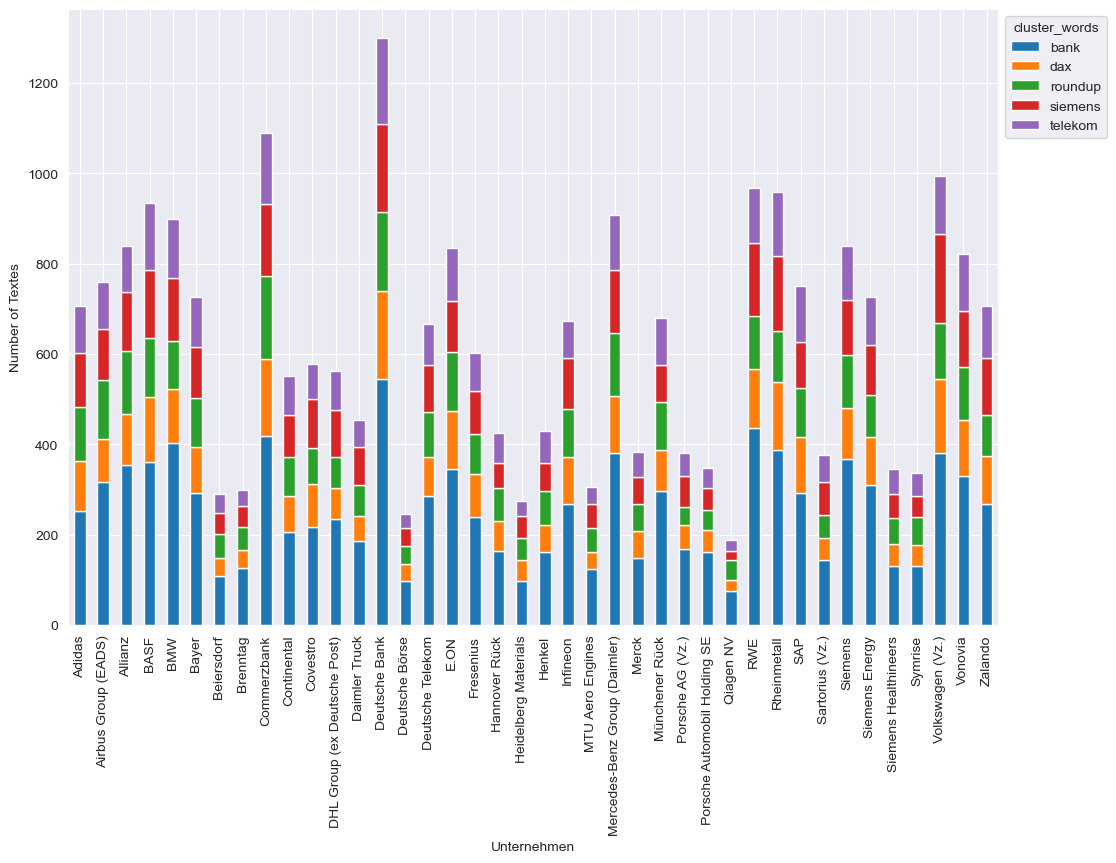

In [117]:
# Find the most important topics per company
grouped_df = df_merged_3_categories_topics.groupby(['Unternehmen', 'cluster_words']).size().reset_index(name='Number_Entries')

# Find the 5 most important topics per company
top_clusters_df = grouped_df.groupby('Unternehmen').apply(lambda x: x.nlargest(5, 'Number_Entries')).reset_index(drop=True)
pivot_table = pd.pivot_table(top_clusters_df, values='Number_Entries', index='Unternehmen', columns='cluster_words', fill_value=0)

# Create chart
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.ylabel('Number of Textes')
plt.legend(title='cluster_words', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Sentiments per topics

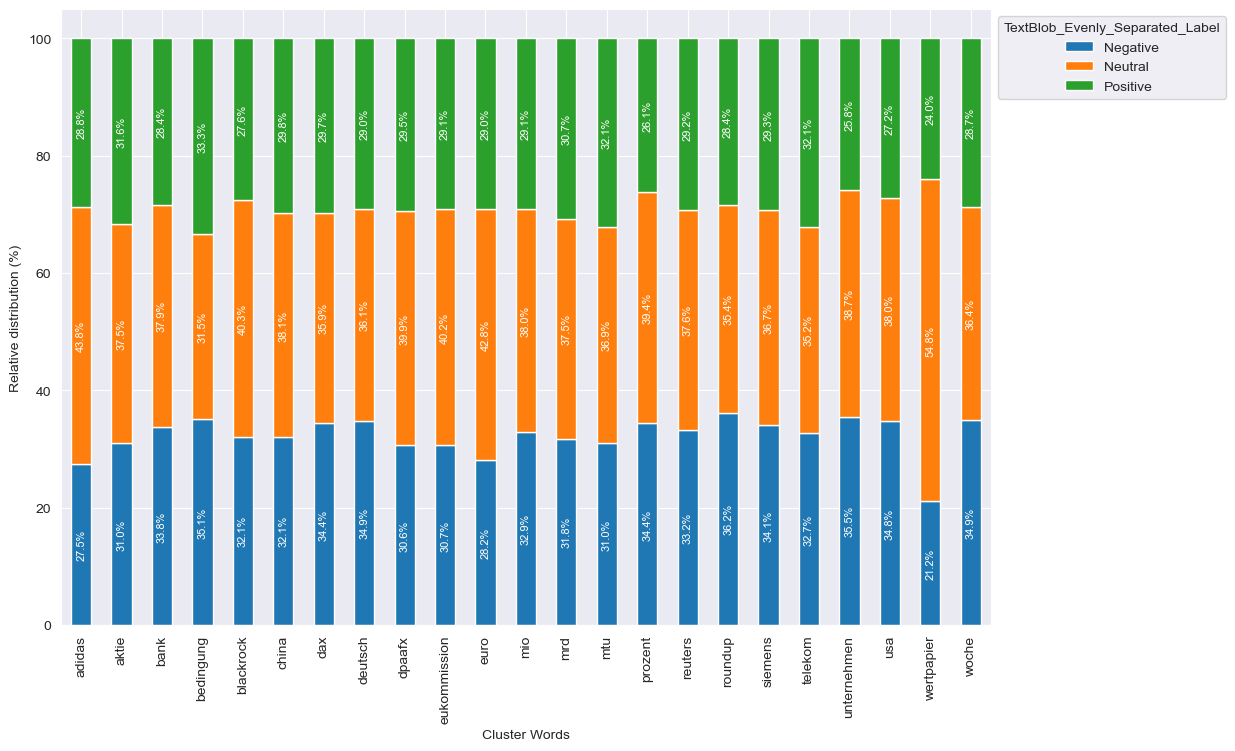

In [118]:
# TextBlob_Evenly_Separated_Label: Distribution of sentiments along the topics
grouped_df = df_merged_3_categories_topics.groupby(['cluster_words', 'TextBlob_Evenly_Separated_Label']).size().reset_index(name='Number_Entries')

# Calculate the relative distribution (percentage) for each row (Cluster Words)
pivot_table = pd.pivot_table(grouped_df, values='Number_Entries', index='cluster_words', columns='TextBlob_Evenly_Separated_Label', fill_value=0)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Create bar chart
ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(12, 8))

# Insert percent values
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center', rotation=90, fontsize=8, color='white')

plt.xlabel('Cluster Words')
plt.ylabel('Relative distribution (%)')
plt.legend(title='TextBlob_Evenly_Separated_Label', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

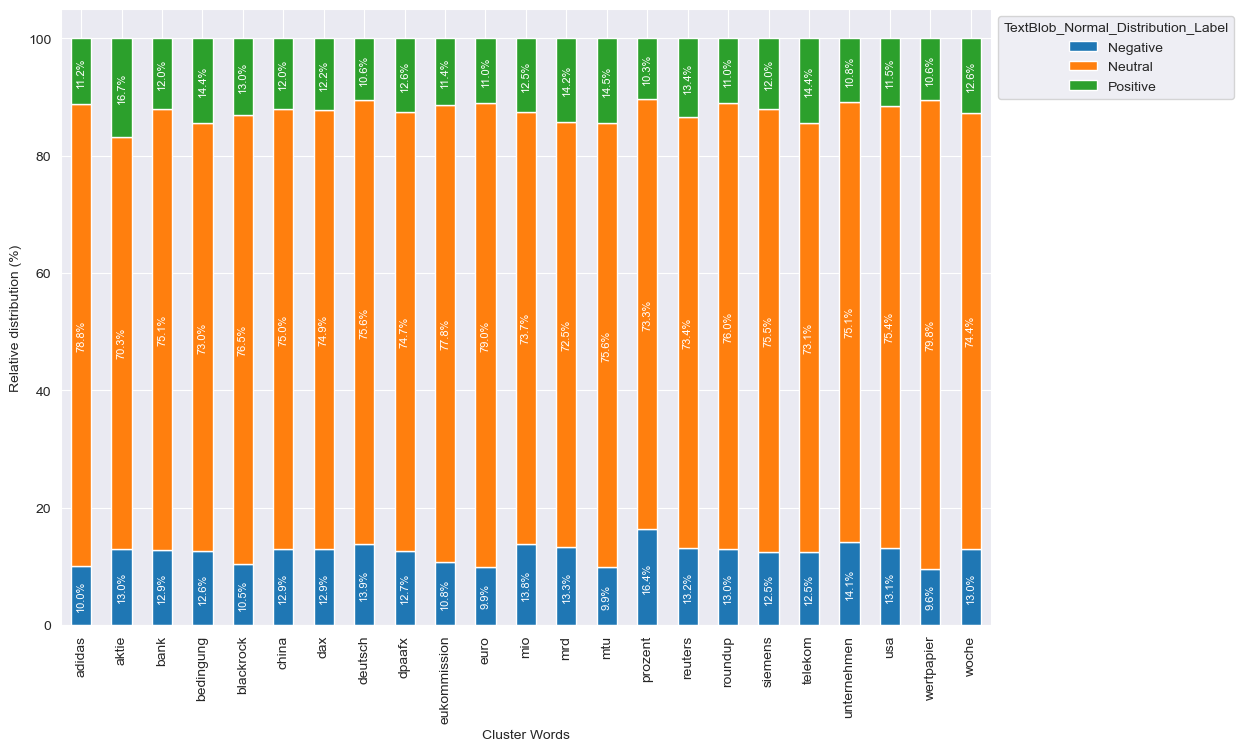

In [119]:
# TextBlob_Normal_Distribution_Label: Distribution of sentiments along the topics
grouped_df = df_merged_3_categories_topics.groupby(['cluster_words', 'TextBlob_Normal_Distribution_Label']).size().reset_index(name='Number_Entries')

# Calculate the relative distribution (percentage) for each row (Cluster Words)
pivot_table = pd.pivot_table(grouped_df, values='Number_Entries', index='cluster_words', columns='TextBlob_Normal_Distribution_Label', fill_value=0)
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Create bar chart
ax = pivot_table_percentage.plot(kind='bar', stacked=True, figsize=(12, 8))

# Insert percent values
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center', rotation=90, fontsize=8, color='white')

plt.xlabel('Cluster Words')
plt.ylabel('Relative distribution (%)')
plt.legend(title='TextBlob_Normal_Distribution_Label', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Stock value per topic

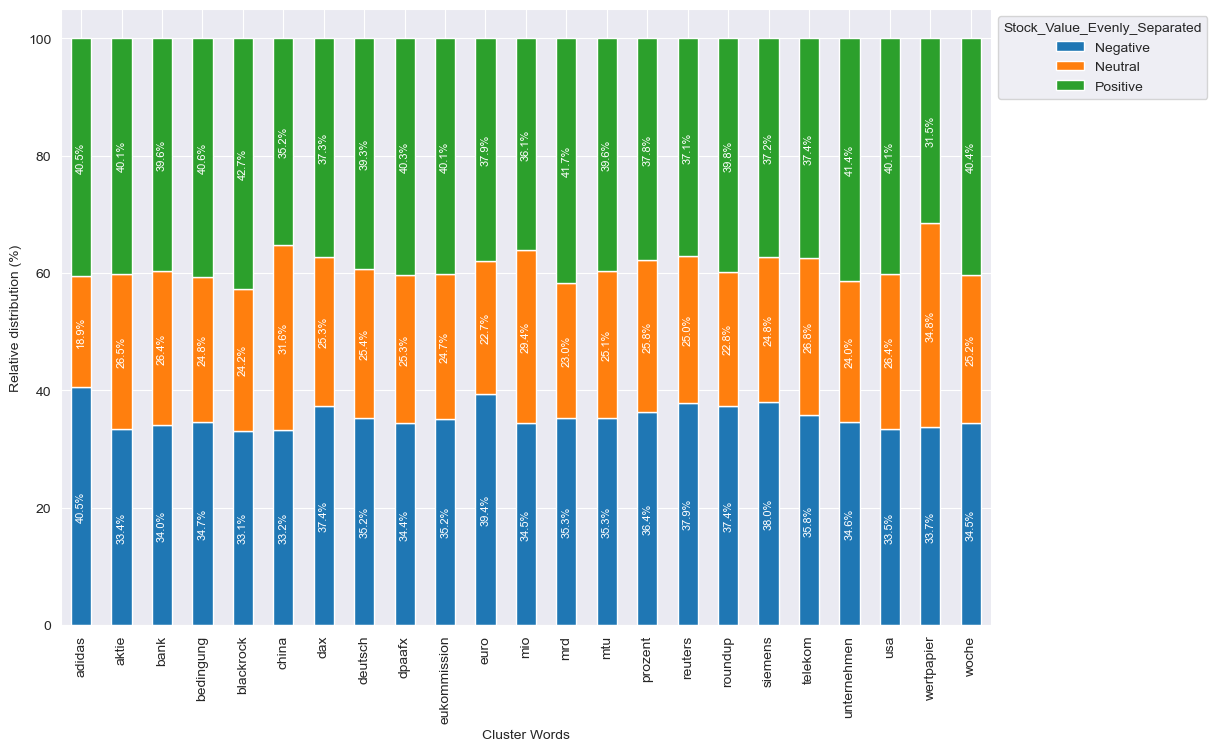

In [120]:
# Stock_Value_Evenly_Separated: Distribution of Stock values per topic
grouped_df = (df_merged_3_categories_topics.groupby(['cluster_words', 'Stock_Value_Evenly_Separated']).size().reset_index(name='Number_Entries'))

# Calculate the relative distribution (percentage) for each row
total_entries = grouped_df.groupby('cluster_words')['Number_Entries'].sum()
grouped_df['Relative_distribution'] = grouped_df.apply(lambda row: (row['Number_Entries'] / total_entries[row['cluster_words']]) * 100, axis=1)
pivot_table = pd.pivot_table(grouped_df, values='Relative_distribution', index='cluster_words', columns='Stock_Value_Evenly_Separated', fill_value=0)

# Create chart
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8))

# Insert percent values
for idx, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    label_text = f'{height:.1f}%'
    ax.annotate(label_text, (x + width / 2, y + height / 2), ha='center', va='center', rotation=90, fontsize=8, color = 'white')

plt.xlabel('Cluster Words')
plt.ylabel('Relative distribution (%)')
plt.legend(title='Stock_Value_Evenly_Separated', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

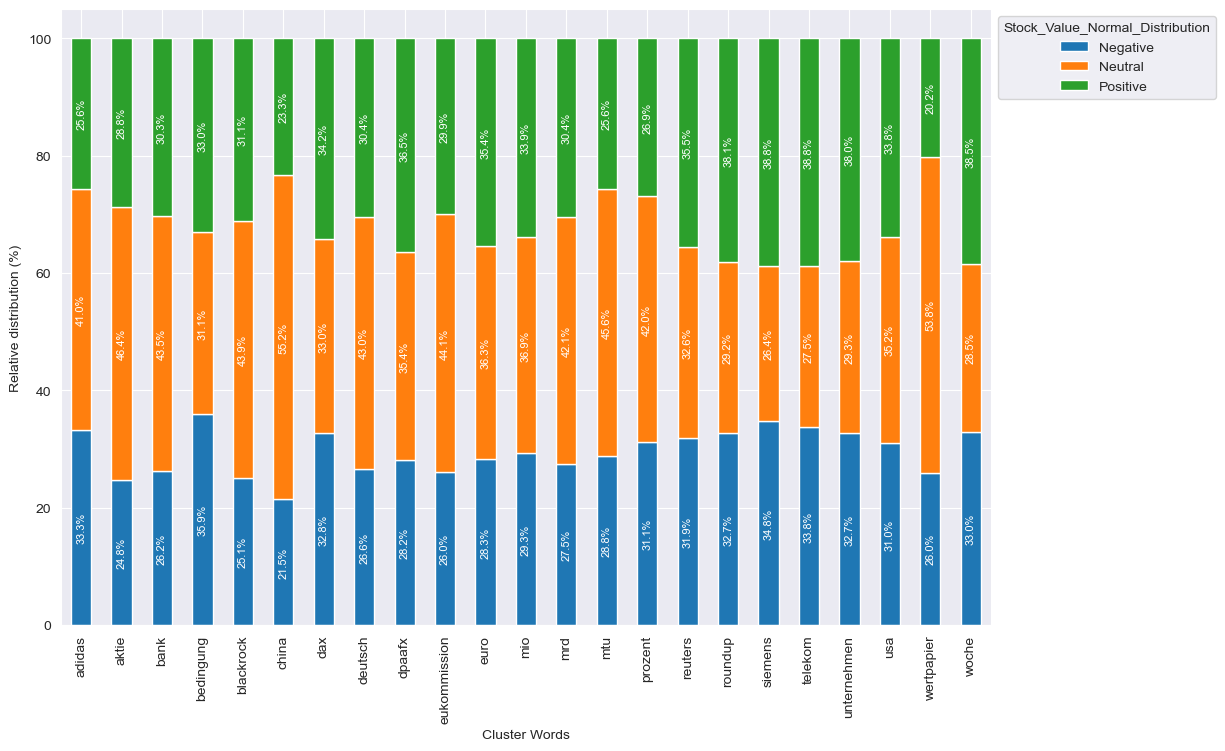

In [121]:
# Stock_Value_Normal_Distribution: Distribution of Stock values per topic
grouped_df = (df_merged_3_categories_topics.groupby(['cluster_words', 'Stock_Value_Normal_Distribution']).size().reset_index(name='Number_Entries'))

# Calculate the relative distribution (percentage) for each row
total_entries = grouped_df.groupby('cluster_words')['Number_Entries'].sum()
grouped_df['Relative_distribution'] = grouped_df.apply(lambda row: (row['Number_Entries'] / total_entries[row['cluster_words']]) * 100, axis=1)
pivot_table = pd.pivot_table(grouped_df, values='Relative_distribution', index='cluster_words', columns='Stock_Value_Normal_Distribution', fill_value=0)

# Create chart
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(12, 8))

# Insert percent values
for idx, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    label_text = f'{height:.1f}%'
    ax.annotate(label_text, (x + width / 2, y + height / 2), ha='center', va='center', rotation=90, fontsize=8, color = 'white')

plt.xlabel('Cluster Words')
plt.ylabel('Relative distribution (%)')
plt.legend(title='Stock_Value_Normal_Distribution', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Sentiment correlation Analysis

### 3 Categories, even separation

#### TextBlob Even Separation

In [23]:
# Create a contingency table
contingency_table_textblob_even = pd.crosstab(df_merged_3_categories['Stock_Value_Evenly_Separated'], df_merged_3_categories['TextBlob_Evenly_Separated_Label'])

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table_textblob_even)

# Output the chi-squared statistic and p-value
print(f"Chi-Squared Statistic: {chi2}")
print(f"P-Value: {p}")

# Interpret the results
alpha = 0.05  # Significance level
if p <= alpha:
    print("There is a significant association between the two categorical variables Stock_Value_Evenly_Separated and TextBlob_Evenly_Separated_Label.")
else:
    print("There is no significant association between the two categorical variables Stock_Value_Evenly_Separated and TextBlob_Evenly_Separated_Label.")

Chi-Squared Statistic: 74.37817173044427
P-Value: 2.6972703877652494e-15
There is a significant association between the two categorical variables Stock_Value_Evenly_Separated and TextBlob_Evenly_Separated_Label.


##### Cramer's V (or Cramer's Phi) and the Phi Coefficient (φ), analysing strength of relationship

In [24]:
# Calculate Cramer's V
n = contingency_table_textblob_even.sum().sum()
min_dim = min(contingency_table_textblob_even.shape) - 1
cramer_v = (chi2 / n) ** 0.5 / min_dim

# Calculate the Phi Coefficient (φ)
phi_coefficient = (chi2 / n) ** 0.5

print(f"Cramer's V: {cramer_v}")
print(f"Phi Coefficient (φ): {phi_coefficient}")

Cramer's V: 0.02300863048948797
Phi Coefficient (φ): 0.04601726097897594


#### Additional info about results
*Modul: Text Analytics*

Yes, it is **possible for Cramer's V (or Cramer's Phi) and the Phi Coefficient (φ) to be close to 0 while the chi-square test identifies a significant relationship**. This can occur when there is a statistically significant association between the variables, but the strength of that association is weak.

The chi-square test primarily assesses the statistical significance of the association, meaning it tells you whether there is evidence that the two categorical variables are related. However, it doesn't provide information about the strength or the practical significance of that relationship.

Cramer's V and the Phi Coefficient provide measures of effect size, indicating how strong the relationship is. A small effect size, reflected in values close to 0, suggests a weak association, while a large effect size indicates a strong association.

So, it's possible for the chi-square test to detect a statistically significant relationship even if the association is weak, leading to low values for Cramer's V and Phi Coefficient. The significance test assesses whether there is any association, while the effect size measures how substantial that association is in practical terms.

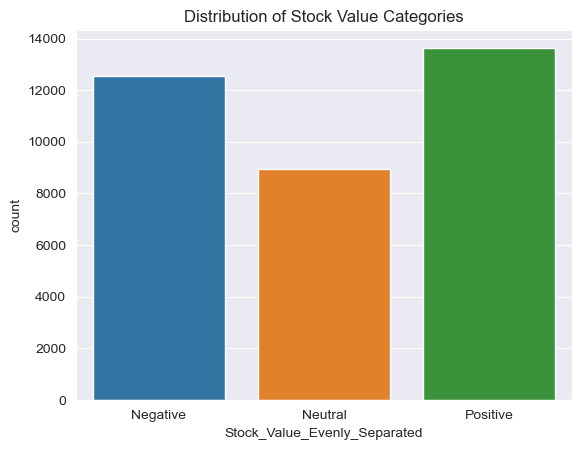

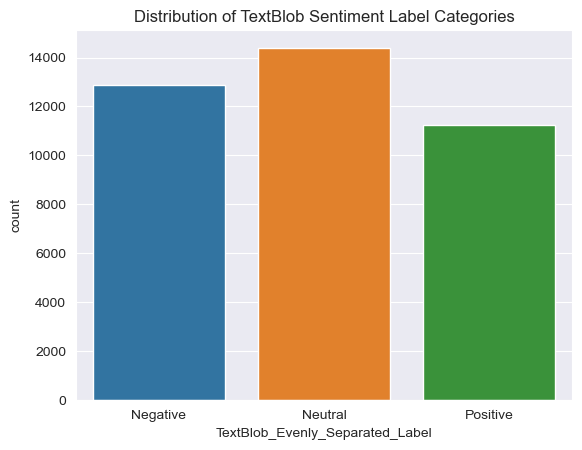

In [25]:
# Define the order for the categories
order = ['Negative', 'Neutral', 'Positive']

# Create bar charts for each categorical variable with the specified order
sns.countplot(data=df_merged_3_categories, x='Stock_Value_Evenly_Separated', order=order)
plt.title('Distribution of Stock Value Categories')
plt.show()

sns.countplot(data=df_merged_3_categories, x='TextBlob_Evenly_Separated_Label', order=order)
plt.title('Distribution of TextBlob Sentiment Label Categories')
plt.show()

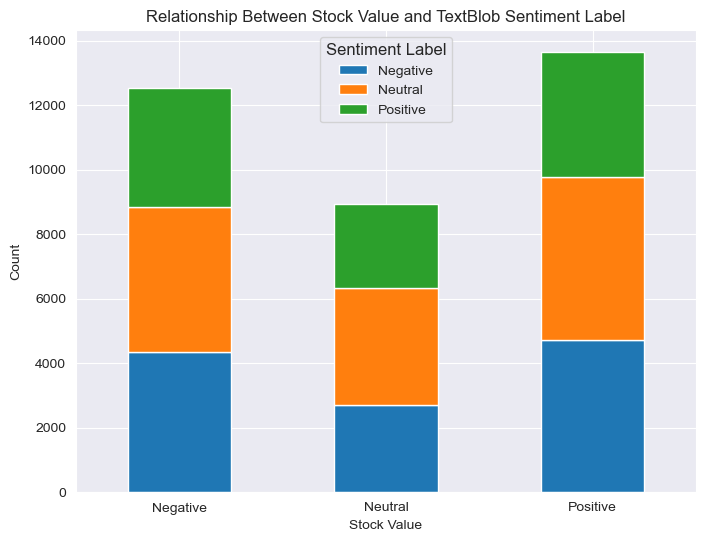

In [26]:
# Create a contingency table to count the co-occurrence of values
contingency_table_even_compare = pd.crosstab(df_merged_3_categories['Stock_Value_Evenly_Separated'], df_merged_3_categories['TextBlob_Evenly_Separated_Label'])

# Define the order of categories
category_order = ['Negative', 'Neutral', 'Positive']

# Create a stacked bar chart
ax = contingency_table_even_compare[category_order].plot(kind='bar', stacked=True, figsize=(8, 6,))

# Add labels and a legend
ax.set_xlabel('Stock Value')
ax.set_ylabel('Count')
ax.set_title('Relationship Between Stock Value and TextBlob Sentiment Label')
ax.legend(title='Sentiment Label', title_fontsize=12)

plt.xticks(rotation=0)  # Keep x-axis labels horizontal

plt.show()

In [27]:
# Create a DataFrame to store the counts
counts_df = pd.DataFrame(index=['Negative', 'Neutral', 'Positive'], columns=['Stock_Value_Evenly_Separated', 'TextBlob_Evenly_Separated_Label'])

# Count how often each category appears for "Stock_Value_Evenly_Separated"
counts_df['Stock_Value_Evenly_Separated'] = df_merged_3_categories['Stock_Value_Evenly_Separated'].value_counts()

# Count how often both "Stock_Value_Evenly_Separated" and "TextBlob_Evenly_Separated_Label" are the same
for category in ['Negative', 'Neutral', 'Positive']:
    counts_df.loc[category, 'TextBlob_Evenly_Separated_Label'] = ((df_merged_3_categories['Stock_Value_Evenly_Separated'] == category) & (df_merged_3_categories['TextBlob_Evenly_Separated_Label'] == category)).sum()

# Print the counts
print(counts_df)

          Stock_Value_Evenly_Separated TextBlob_Evenly_Separated_Label
Negative                         12538                            4356
Neutral                           8949                            3614
Positive                         13637                            3868


#### NLTK Even Separation

In [28]:
# Create a contingency table
contingency_table_nltk_even = pd.crosstab(df_merged_3_categories['Stock_Value_Evenly_Separated'], df_merged_3_categories['NLTK_Evenly_Separated_Label'])

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table_nltk_even)

# Output the chi-squared statistic and p-value
print(f"Chi-Squared Statistic: {chi2}")
print(f"P-Value: {p}")

# Interpret the results
alpha = 0.05  # Significance level
if p <= alpha:
    print("There is a significant association between the two categorical variables Stock_Value_Evenly_Separated and NLTK_Evenly_Separated_Label.")
else:
    print("There is no significant association between the two categorical variables Stock_Value_Evenly_Separated and NLTK_Evenly_Separated_Label.")

Chi-Squared Statistic: 44.33370388660063
P-Value: 5.469221885684718e-09
There is a significant association between the two categorical variables Stock_Value_Evenly_Separated and NLTK_Evenly_Separated_Label.


##### Cramer's V (or Cramer's Phi) and the Phi Coefficient (φ), analysing strength of relationship

In [29]:
# Calculate Cramer's V
n = contingency_table_nltk_even.sum().sum()
min_dim = min(contingency_table_nltk_even.shape) - 1
cramer_v = (chi2 / n) ** 0.5 / min_dim

# Calculate the Phi Coefficient (φ)
phi_coefficient = (chi2 / n) ** 0.5

print(f"Cramer's V: {cramer_v}")
print(f"Phi Coefficient (φ): {phi_coefficient}")

Cramer's V: 0.017763765369023
Phi Coefficient (φ): 0.035527530738046


### 3 Categories, normal distribution

#### TextBlob Normal Distribution

In [30]:
# Create a contingency table
contingency_table_textblob_normal = pd.crosstab(df_merged_3_categories['Stock_Value_Normal_Distribution'], df_merged_3_categories['TextBlob_Normal_Distribution_Label'])

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table_textblob_normal)

# Output the chi-squared statistic and p-value
print(f"Chi-Squared Statistic: {chi2}")
print(f"P-Value: {p}")

# Interpret the results
alpha = 0.05  # Significance level
if p <= alpha:
    print("There is a significant association between the two categorical variables Stock_Value_Normal_Distribution and TextBlob_Normal_Distribution_Label.")
else:
    print("There is no significant association between the two categorical variables Stock_Value_Normal_Distribution and TextBlob_Normal_Distribution_Label.")

Chi-Squared Statistic: 1.190344963595181
P-Value: 0.8796856842078422
There is no significant association between the two categorical variables Stock_Value_Normal_Distribution and TextBlob_Normal_Distribution_Label.


##### Cramer's V (or Cramer's Phi) and the Phi Coefficient (φ), analysing strength of relationship

In [31]:
# Calculate Cramer's V
n = contingency_table_textblob_normal.sum().sum()
min_dim = min(contingency_table_textblob_normal.shape) - 1
cramer_v = (chi2 / n) ** 0.5 / min_dim

# Calculate the Phi Coefficient (φ)
phi_coefficient = (chi2 / n) ** 0.5

print(f"Cramer's V: {cramer_v}")
print(f"Phi Coefficient (φ): {phi_coefficient}")

Cramer's V: 0.0029107468723766658
Phi Coefficient (φ): 0.0058214937447533316


#### NLTK Normal Distribution

In [32]:
# Create a contingency table
contingency_table_nltk_normal = pd.crosstab(df_merged_3_categories['Stock_Value_Normal_Distribution'], df_merged_3_categories['NLTK_Normal_Distribution_Label'])

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table_nltk_normal)

# Output the chi-squared statistic and p-value
print(f"Chi-Squared Statistic: {chi2}")
print(f"P-Value: {p}")

# Interpret the results
alpha = 0.05  # Significance level
if p <= alpha:
    print("There is a significant association between the two categorical variables Stock_Value_Normal_Distribution and NLTK_Normal_Distribution_Label.")
else:
    print("There is no significant association between the two categorical variables Stock_Value_Normal_Distribution and NLTK_Normal_Distribution_Label.")

Chi-Squared Statistic: 9.298877653052285
P-Value: 0.0540480069893467
There is no significant association between the two categorical variables Stock_Value_Normal_Distribution and NLTK_Normal_Distribution_Label.


##### Cramer's V (or Cramer's Phi) and the Phi Coefficient (φ), analysing strength of relationship

In [33]:
# Calculate Cramer's V
n = contingency_table_nltk_normal.sum().sum()
min_dim = min(contingency_table_nltk_normal.shape) - 1
cramer_v = (chi2 / n) ** 0.5 / min_dim

# Calculate the Phi Coefficient (φ)
phi_coefficient = (chi2 / n) ** 0.5

print(f"Cramer's V: {cramer_v}")
print(f"Phi Coefficient (φ): {phi_coefficient}")

Cramer's V: 0.00813548197003955
Phi Coefficient (φ): 0.0162709639400791
